<a href="https://colab.research.google.com/github/VonFaust/World-BM-monthly-from-12-98---02-21/blob/main/BM%20checking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import sys

import pandas as pd
import pandas_datareader.data as web
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from arch import arch_model

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
p = print

p('Machine: {} {}\n'.format(os.uname().sysname,os.uname().machine))
p(sys.version)

Machine: Linux x86_64

3.6.9 (default, Oct  8 2020, 12:12:24) 
[GCC 8.4.0]


In [ ]:
end = '2015-01-01'
start = '2007-01-01'
get_px = lambda x: web.DataReader(x, 'yahoo', start=start, end=end)['Adj Close']

symbols = ['SPY','TLT','MSFT']
# raw adjusted close prices
data = pd.DataFrame({sym:get_px(sym) for sym in symbols})
# log returns
lrets = np.log(data/data.shift(1)).dropna()

In [ ]:
pip install arch

     |████████████████████████████████| 798kB 5.6MB/s 


In [ ]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

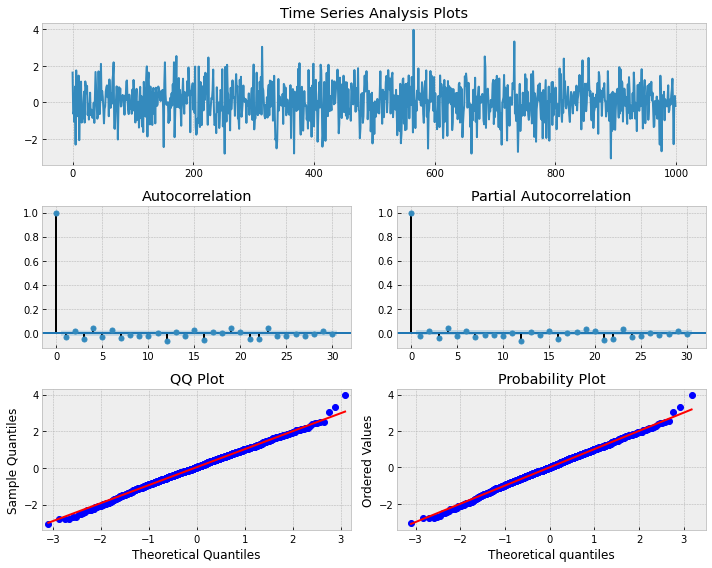

In [ ]:
np.random.seed(1)

# plot of discrete white noise
randser = np.random.normal(size=1000)
tsplot(randser, lags=30)

In [ ]:
p("Random Series\n -------------\nmean: {:.3f}\nvariance: {:.3f}\nstandard deviation: {:.3f}"
.format(randser.mean(), randser.var(), randser.std()))

# Random Series
# -------------
# mean: 0.039 
# variance: 0.962
# standard deviation: 0.981

Random Series
 -------------
mean: 0.039
variance: 0.962
standard deviation: 0.981


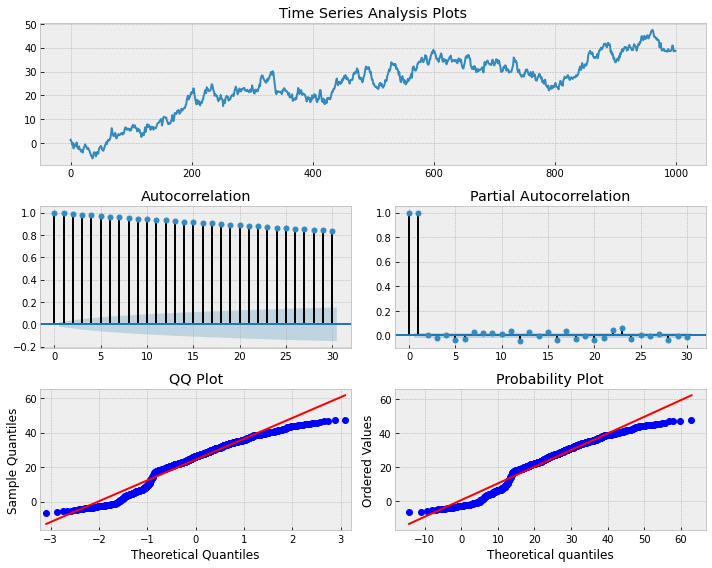

In [ ]:
# Random Walk without a drift

np.random.seed(1)
n_samples = 1000

x = w = np.random.normal(size=n_samples)
for t in range(n_samples):
    x[t] = x[t-1] + w[t]

_ = tsplot(x, lags=30)

1000

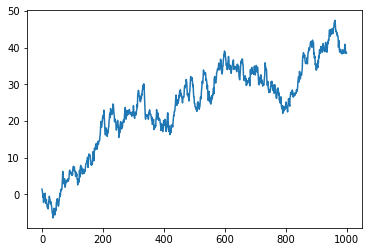

In [ ]:
plt.plot(x)
np.size(x)

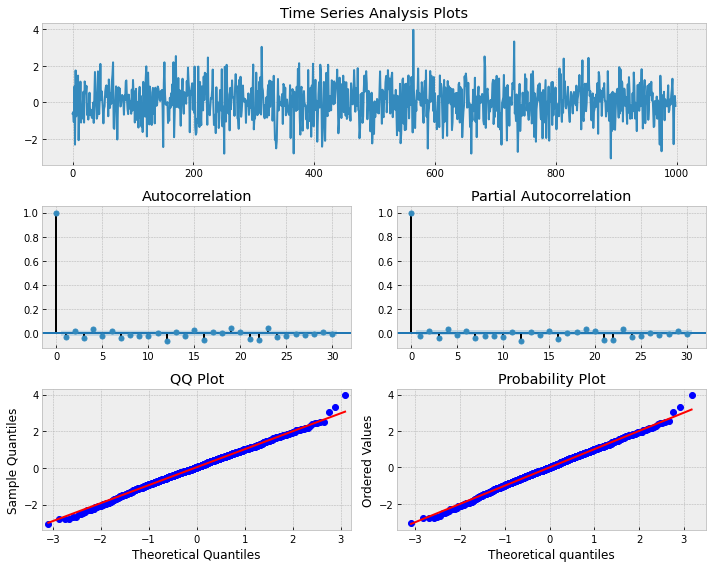

In [ ]:
# First difference of simulated Random Walk series

_ = tsplot(np.diff(x), lags=30)

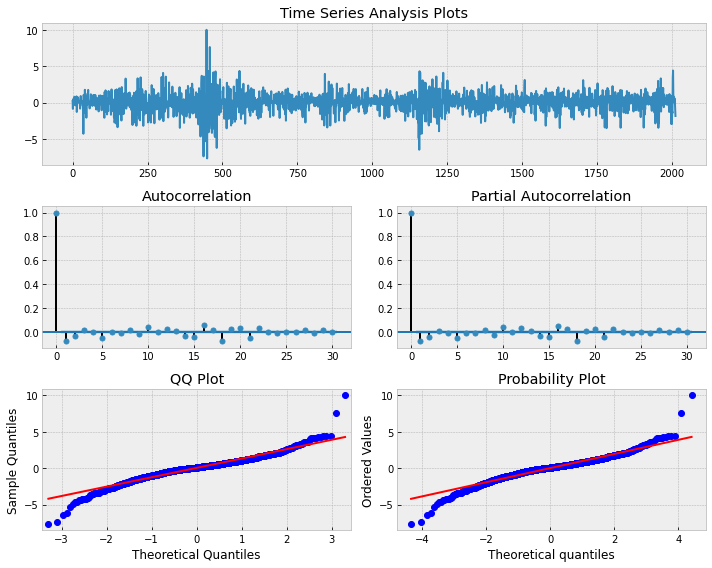

In [ ]:
# First difference of SPY prices
_ = tsplot(np.diff(data.SPY), lags=30)

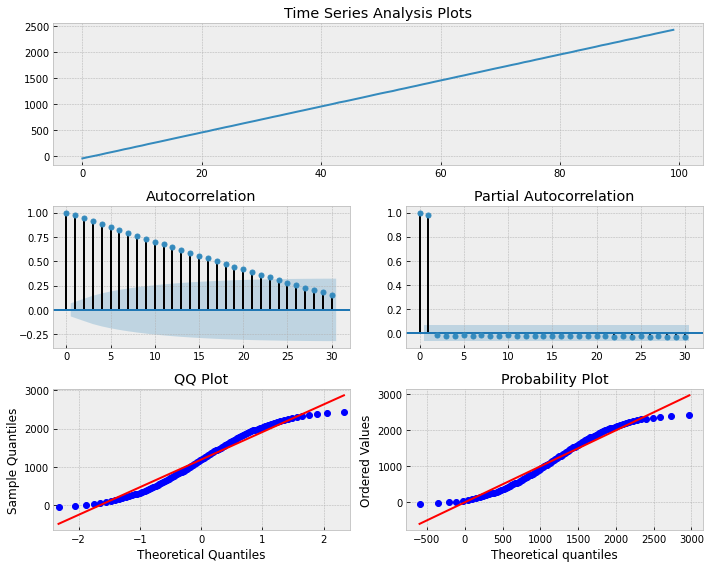

In [ ]:
# simulate linear trend
# example Firm ABC sales are -$50 by default and +$25 at every time step

w = np.random.randn(100)
y = np.empty_like(w)

b0 = -50.
b1 = 25.
for t in range(len(w)):
    y[t] = b0 + b1*t + w[t]
    
_ = tsplot(y,lags = 30) 

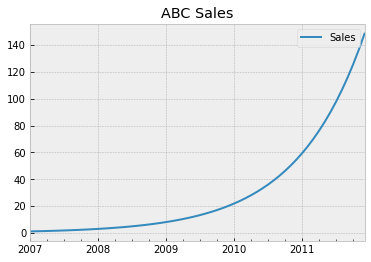

In [ ]:
# Simulate ABC exponential growth

# fake dates
idx = pd.date_range('2007-01-01', '2012-01-01', freq='M')

# fake sales increasing at exponential rate
sales = [np.exp( x/12 ) for x in range(1, len(idx)+1)]

# create dataframe and plot
df = pd.DataFrame(sales, columns=['Sales'], index=idx)

with plt.style.context('bmh'):
    df.plot()
    plt.title('ABC Sales')

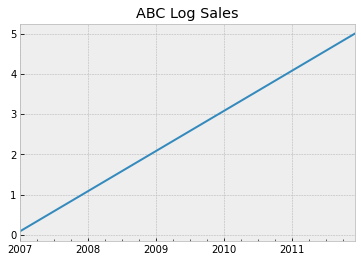

In [ ]:
# ABC log sales 

with plt.style.context('bmh'):
    pd.Series(np.log(sales), index=idx).plot()
    plt.title('ABC Log Sales')

AttributeError: ignored

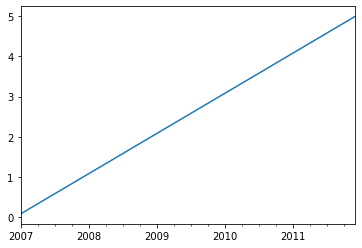

In [ ]:
plt.style.context('bmh')
pd.Series(np.log(sales), index=idx).plot().style.context('bmh')
plt.title('ABC Log Sales')

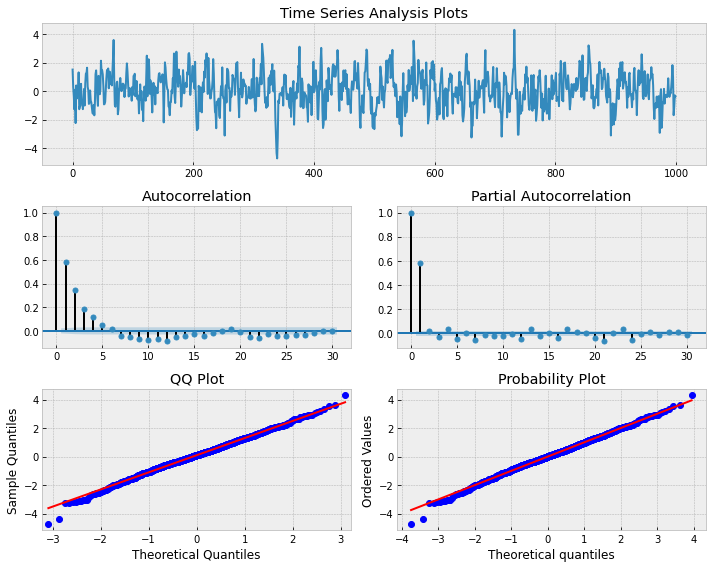

In [ ]:
# Simulate an AR(1) process with alpha = 0.6

np.random.seed(1)
n_samples = int(1000)
a = 0.6
x = w = np.random.normal(size=n_samples)

for t in range(n_samples):
    x[t] = a*x[t-1] + w[t]
    
_ = tsplot(x, lags=30)

In [ ]:
# Fit an AR(p) model to simulated AR(1) model with alpha = 0.6

mdl = smt.AR(x).fit(maxlag=30, ic='aic', trend='nc')
%time est_order = smt.AR(x).select_order(maxlag=30, ic='aic', trend='nc')

true_order = 1
p('\nalpha estimate: {:3.5f} | best lag order = {}'
  .format(mdl.params[0], est_order))
p('\ntrue alpha = {} | true order = {}'
  .format(a, true_order))

CPU times: user 28.1 s, sys: 22.6 s, total: 50.7 s
Wall time: 25.7 s

alpha estimate: 0.58227 | best lag order = 1

true alpha = 0.6 | true order = 1


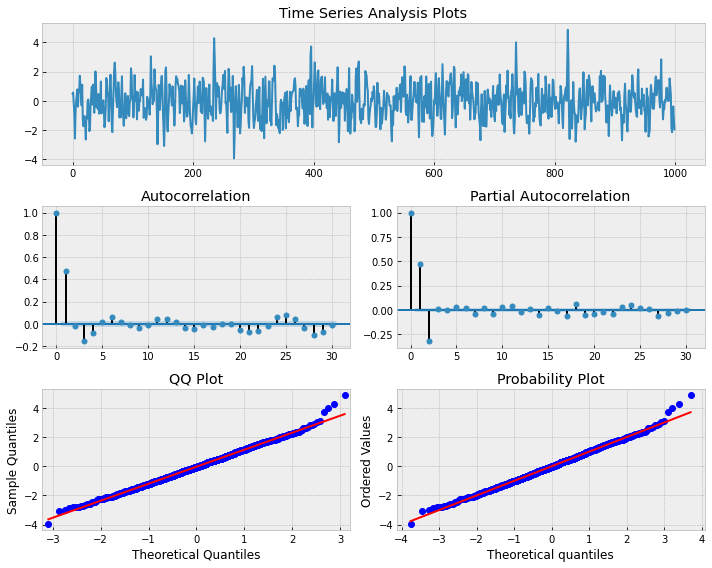

In [ ]:
# Simulate an AR(2) process

n = int(1000)
alphas = np.array([.666, -.333])
betas = np.array([0.])

# Python requires us to specify the zero-lag value which is 1
# Also note that the alphas for the AR model must be negated
# We also set the betas for the MA equal to 0 for an AR(p) model
# For more information see the examples at statsmodels.org
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ar2 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
_ = tsplot(ar2, lags=30)

In [ ]:
# Fit an AR(p) model to simulated AR(2) process

max_lag = 10
mdl = smt.AR(ar2).fit(maxlag=max_lag, ic='aic', trend='nc')
est_order = smt.AR(ar2).select_order(
    maxlag=max_lag, ic='aic', trend='nc')

true_order = 2
p('\ncoef estimate: {:3.4f} {:3.4f} | best lag order = {}'
  .format(mdl.params[0],mdl.params[1], est_order))
p('\ntrue coefs = {} | true order = {}'
  .format([.666,-.333], true_order))
  
# coef estimate: 0.6291 -0.3196 | best lag order = 2
# true coefs = [0.666, -0.333] | true order = 2


coef estimate: 0.6291 -0.3196 | best lag order = 2

true coefs = [0.666, -0.333] | true order = 2


In [ ]:
# Select best lag order for MSFT returns

max_lag = 30
mdl = smt.AR(lrets.MSFT).fit(maxlag=max_lag, ic='aic', trend='nc')
est_order = smt.AR(lrets.MSFT).select_order(
    maxlag=max_lag, ic='aic', trend='nc')

p('best estimated lag order = {}'.format(est_order))

# best estimated lag order = 23

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


best estimated lag order = 23


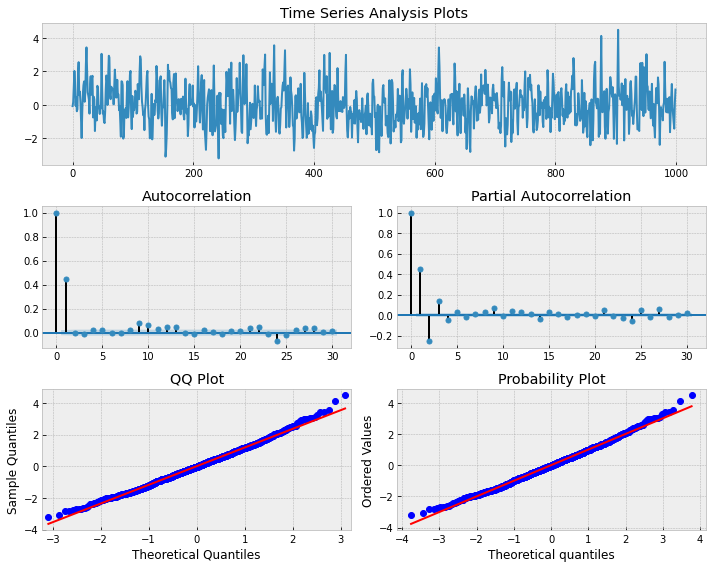

In [ ]:
# Simulate an MA(1) process

n = int(1000)

# set the AR(p) alphas equal to 0
alphas = np.array([0.])
betas = np.array([0.6])

# add zero-lag and negate alphas
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ma1 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
_ = tsplot(ma1, lags=30)

In [ ]:
# Fit the MA(1) model to our simulated time series
# Specify ARMA model with order (p, q)

max_lag = 30
mdl = smt.ARMA(ma1, order=(0, 1)).fit(
    maxlag=max_lag, method='mle', trend='nc')
p(mdl.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(0, 1)   Log Likelihood               -1427.789
Method:                           mle   S.D. of innovations              1.009
Date:                Tue, 29 Dec 2020   AIC                           2859.578
Time:                        09:27:39   BIC                           2869.393
Sample:                             0   HQIC                          2863.308
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.y        0.5898      0.025     23.604      0.000       0.541       0.639
                                    Roots                                    
                  Real          Imaginary           M

In [ ]:
0.5898+1.96*0.025

0.6388

In [ ]:
0.5898-1.964*0.025

0.5407

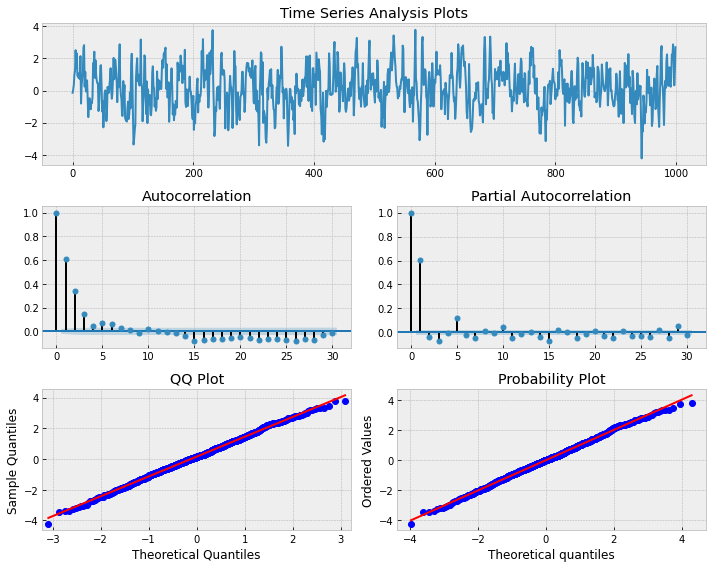

In [ ]:
# Simulate MA(3) process with betas 0.6, 0.4, 0.2

n = int(1000)
alphas = np.array([0.])
betas = np.array([0.6, 0.4, 0.2])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ma3 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n)
_ = tsplot(ma3, lags=30)

In [ ]:
# Fit MA(3) model to simulated time series

max_lag = 30
mdl = smt.ARMA(ma3, order=(0, 3)).fit(
    maxlag=max_lag, method='mle', trend='nc')
p(mdl.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(0, 3)   Log Likelihood               -1438.010
Method:                           mle   S.D. of innovations              1.019
Date:                Tue, 29 Dec 2020   AIC                           2884.020
Time:                        09:35:26   BIC                           2903.651
Sample:                             0   HQIC                          2891.481
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.y        0.6443      0.031     20.736      0.000       0.583       0.705
ma.L2.y        0.4364      0.036     12.182      0.000       0.366       0.507
ma.L3.y        0.2103      0.031      6.802      0.0

In [ ]:
0.6443-0.031*1.96

0.58354

In [ ]:
0.6443+0.031*1.96

0.70506

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                              ARMA Model Results                              
Dep. Variable:                    SPY   No. Observations:                 2013
Model:                     ARMA(0, 3)   Log Likelihood                5756.953
Method:                           mle   S.D. of innovations              0.014
Date:                Tue, 29 Dec 2020   AIC                         -11505.906
Time:                        09:56:52   BIC                         -11483.477
Sample:                             0   HQIC                        -11497.673
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.SPY     -0.0959      0.022     -4.314      0.000      -0.139      -0.052
ma.L2.SPY     -0.0737      0.023     -3.256      0.001      -0.118      -0.029
ma.L3.SPY      0.0274      0.022      1.260      0.2

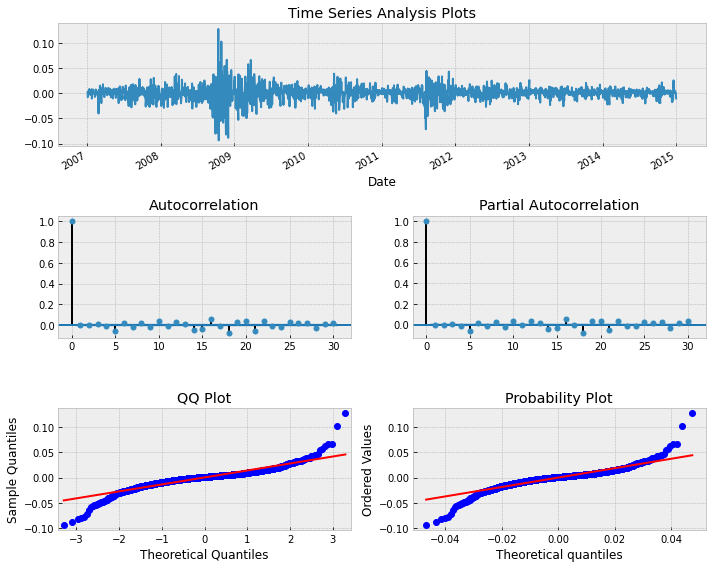

In [ ]:
# Fit MA(3) to SPY returns

max_lag = 30
Y = lrets.SPY
mdl = smt.ARMA(Y, order=(0, 3)).fit(
    maxlag=max_lag, method='mle', trend='nc')
p(mdl.summary())
_ = tsplot(mdl.resid, lags=max_lag)

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 5000
Model:                     ARMA(2, 2)   Log Likelihood               -7059.362
Method:                           mle   S.D. of innovations              0.993
Date:                Tue, 29 Dec 2020   AIC                          14128.725
Time:                        10:21:32   BIC                          14161.311
Sample:                             0   HQIC                         14140.145
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y        0.4574      0.054      8.426      0.000       0.351       0.564
ar.L2.y       -0.2409      0.015    -15.795      0.000      -0.271      -0.211
ma.L1.y        0.5236      0.055      9.487      0.0

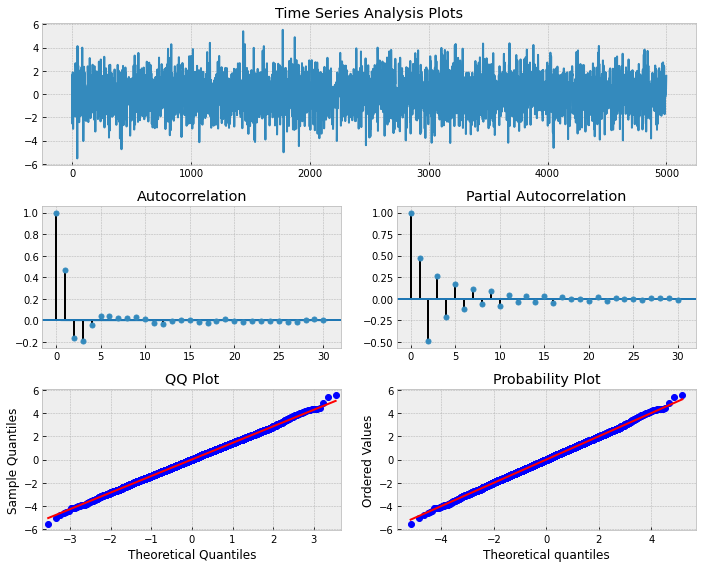

In [ ]:
# Simulate an ARMA(2, 2) model with alphas=[0.5,-0.25] and betas=[0.5,-0.3]
max_lag = 30

n = int(5000) # lots of samples to help estimates
burn = int(n/10) # number of samples to discard before fit

alphas = np.array([0.5, -0.25])
betas = np.array([0.5, -0.3])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

arma22 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
_ = tsplot(arma22, lags=max_lag)

mdl = smt.ARMA(arma22, order=(2, 2)).fit(
    maxlag=max_lag, method='mle', trend='nc', burnin=burn)
p(mdl.summary())


aic: 14218.79634 | order: (3, 2)


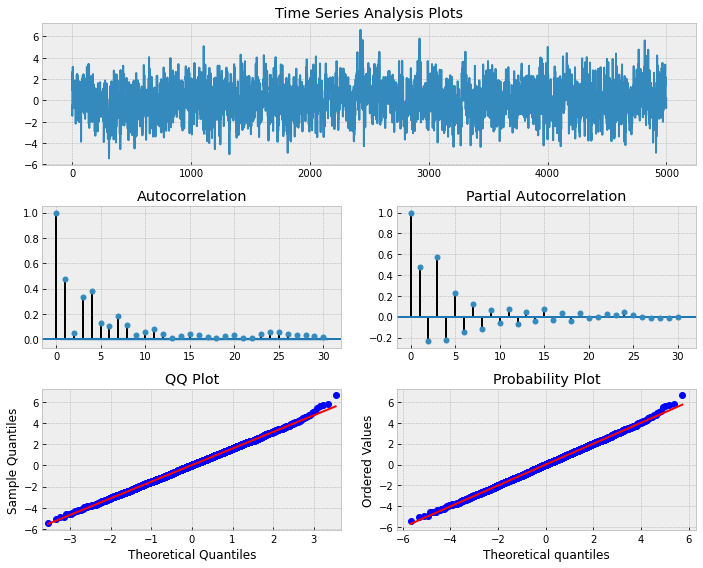

In [ ]:
# Simulate an ARMA(3, 2) model with alphas=[0.5,-0.25,0.4] and betas=[0.5,-0.3]

max_lag = 30

n = int(5000)
burn = 2000

alphas = np.array([0.5, -0.25, 0.4])
betas = np.array([0.5, -0.3])

ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

arma32 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
_ = tsplot(arma32, lags=max_lag)

# pick best order by aic 
# smallest aic value wins
best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(5)
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(arma32, order=(i, j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


p('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

# aic: 14108.27213 | order: (3, 2)

In [ ]:
# Fit ARMA model to SPY returns

best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(5) # [0,1,2,3,4,5]
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(lrets['SPY'], order=(i, j)).fit(
                method='mle', trend='nc'
            )
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


p('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

# aic: -11518.22902 | order: (4, 4)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored wh

aic: -11520.47508 | order: (4, 3)


In [ ]:
max_lag = 30
Y = lrets.SPY
mdl = smt.ARMA(Y, order=(4, 3)).fit(
    maxlag=max_lag, method='mle', trend='nc')

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


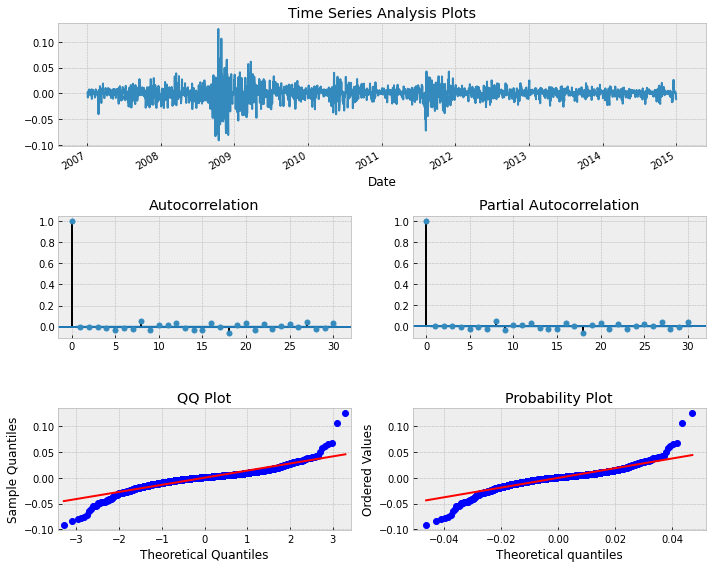

In [ ]:
_ = tsplot(mdl.resid, lags=max_lag)

In [ ]:
mdl.resid

Date
2007-01-04    0.002120
2007-01-05   -0.007817
2007-01-08    0.004010
2007-01-09   -0.001113
2007-01-10    0.003794
                ...   
2014-12-24    0.000809
2014-12-26    0.002696
2014-12-29    0.001911
2014-12-30   -0.004545
2014-12-31   -0.010970
Length: 2013, dtype: float64

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored wh

aic: -11520.47508 | order: (4, 0, 3)


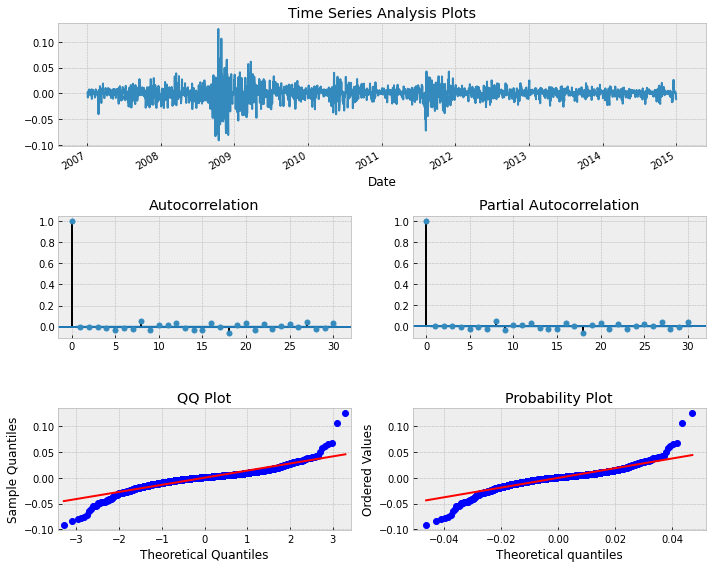

In [ ]:
# Fit ARIMA(p, d, q) model to SPY Returns
# pick best order and final model based on aic

best_aic = np.inf 
best_order = None
best_mdl = None

pq_rng = range(5) # [0,1,2,3,4]
d_rng = range(2) # [0,1]
for i in pq_rng:
    for d in d_rng:
        for j in pq_rng:
            try:
                tmp_mdl = smt.ARIMA(lrets.SPY, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


p('aic: {:6.5f} | order: {}'.format(best_aic, best_order))
# aic: -11518.22902 | order: (4, 0, 4)

# ARIMA model resid plot
_ = tsplot(best_mdl.resid, lags=30)

In [4]:
pip install yfinance

     |████████████████████████████████| 5.5MB 6.6MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22616 sha256=4a1ac134ee0af20992f2ca823964e9d08bda95b748541755cc74b02dc30c40e3
  Stored in directory: /root/.cache/pip/wheels/04/98/cc/2702a4242d60bdc14f48b4557c427ded1fe92aedf257d4565c
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [77]:
import yfinance as yf
import pandas as pd
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt

#define the ticker symbol
tickerSymbol = '^TA125.TA'

#get data on this ticker
tickerData = yf.Ticker(tickerSymbol)

#get the historical prices for this ticker
TA125 = tickerData.history(interval ='1mo', start='1992-1-1', end='2021-3-21')

# Drop unwanted columns
TA125 = TA125.drop(TA125.columns[[0, 1, 2, 5,6, 4]], axis=1) 

# Calculate Return and insert to the DF
TA125['Return']= TA125['Close'].pct_change()
TA125['Rolling Window Return'] = TA125['Return'].rolling(12).mean()
TA125['Rolling Window Std'] = TA125['Return'].rolling(12).std()
#Yearly returns ( (i/i-12) - 1) in monthly increments
TA125['Rolling Yearly Return'] = (TA125['Close'].iloc[::] / TA125['Close'].shift(12)-1)

#Accumulative Return
link = r'https://raw.githubusercontent.com/VonFaust/World-BM-monthly-from-12-98---02-21/main/World%20BM.csv'
MSCI = pd.read_csv(link, error_bad_lines=False)
MSCI.set_index('Date', inplace=True)
MSCI.index = pd.to_datetime(test.index)
MSCI['Return']= MSCI['Price'].pct_change()
MSCI['Rolling Window Return'] = MSCI['Return'].rolling(12).mean()
MSCI['Rolling Window Std'] = MSCI['Return'].rolling(12).std()
MSCI['Rolling Yearly Return'] = (MSCI['Price'].iloc[::] / MSCI['Price'].shift(12)-1)

#define the ticker symbol
tickerSymbol = 'TELBOND60.TA'

#get data on this ticker
tickerData = yf.Ticker(tickerSymbol)

#get the historical prices for this ticker
TB60 = tickerData.history(interval ='1mo', start='1992-1-1', end='2021-3-21')

# Drop unwanted columns
#TB60 = TB60.drop(TB60.columns[[0, 1, 2, 5,6, 4]], axis=1) 
TB60.to_excel('TB60.xls') 
files.download('TB60.xls')

#Download Excel
#TA125.to_excel('TA125.xls') 
#files.download('TA125.xls')
#MSCI.to_excel('MSCI.xls') 
#files.download('MSCI.xls')


- TELBOND60.TA: No data found for this date range, symbol may be delisted


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

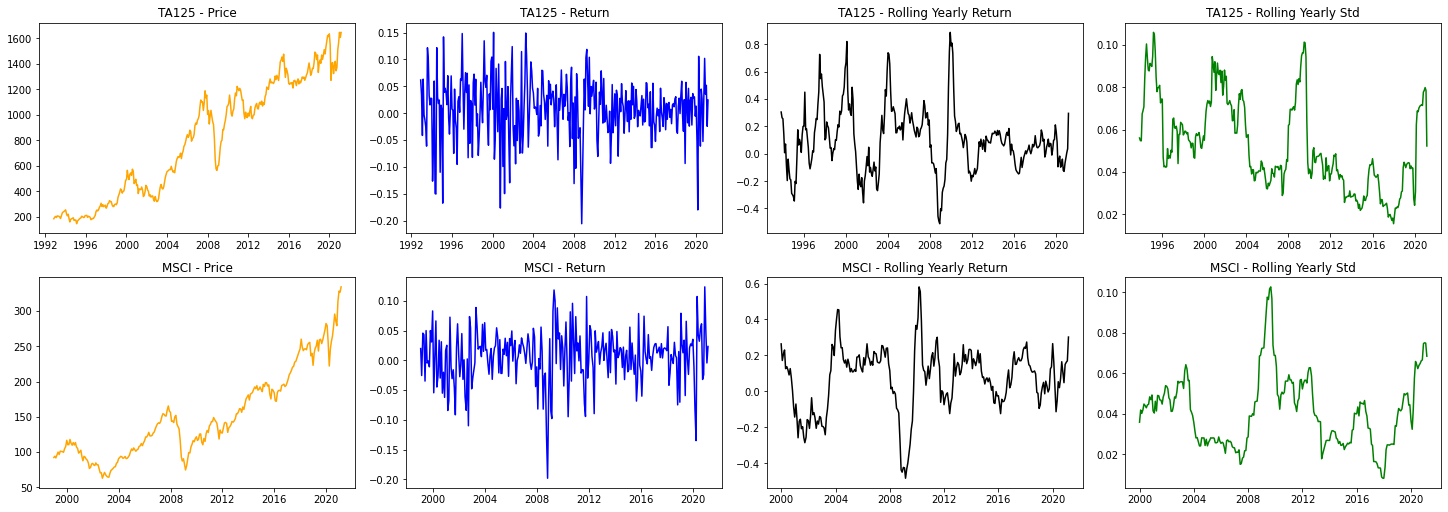

In [75]:
####Graphing 

fig, axs = plt.subplots(2, 4,figsize=(20, 7),constrained_layout= True)



axs[0,0].plot(TA125['Close'],color='orange')
axs[0,0].set_title('TA125 - Price')

axs[0,1].plot(TA125['Return'],color='blue')
axs[0,1].set_title("TA125 - Return")

axs[0,2].plot(TA125['Rolling Yearly Return'],color='black')
axs[0,2].set_title("TA125 - Rolling Yearly Return")

axs[0,3].plot(TA125['Rolling Window Std'],color='green')
axs[0,3].set_title("TA125 - Rolling Yearly Std")


axs[1,0].plot(MSCI['Price'],color='orange')
axs[1,0].set_title("MSCI - Price")

axs[1,1].plot(MSCI['Return'],color='blue')
axs[1,1].set_title("MSCI - Return")

axs[1,2].plot(MSCI['Rolling Yearly Return'],color='black')
axs[1,2].set_title("MSCI - Rolling Yearly Return")

axs[1,3].plot(MSCI['Rolling Window Std'],color='green')
axs[1,3].set_title("MSCI - Rolling Yearly Std")

plt.savefig('MSCI TA125.png')
files.download('MSCI TA125.png')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

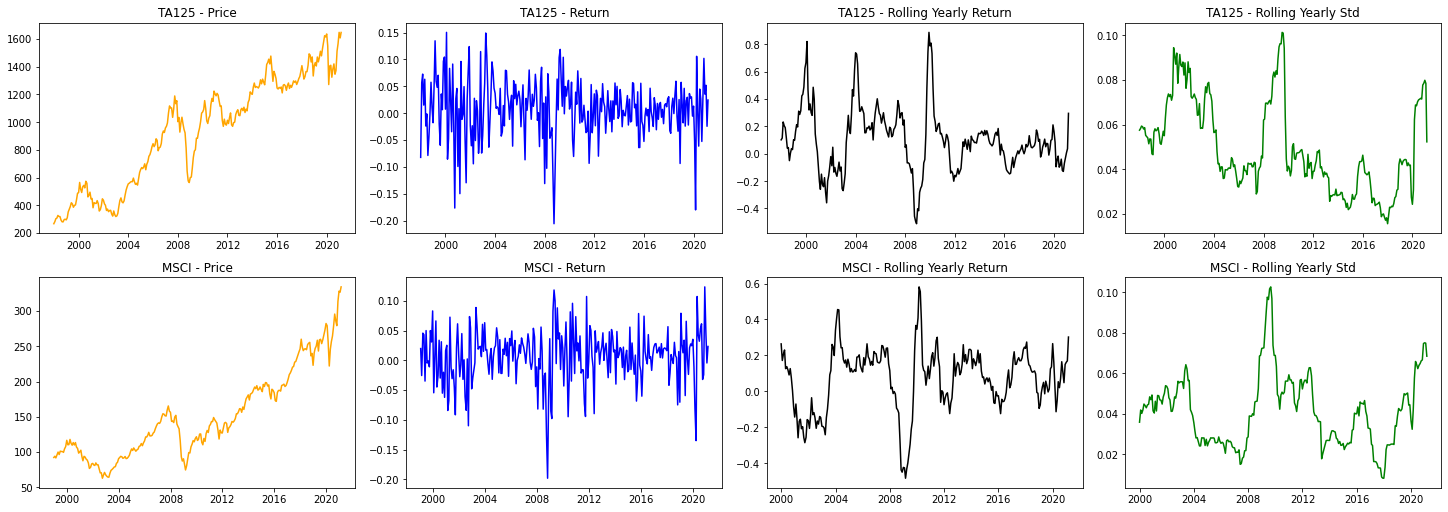

In [91]:
### Gaphing same dates
fig, axs = plt.subplots(2, 4,figsize=(20, 7),constrained_layout= True)



axs[0,0].plot(TA125[TA125.index>='01-01-1998']['Close'],color='orange')
axs[0,0].set_title('TA125 - Price')

axs[0,1].plot(TA125[TA125.index>='01-01-1998']['Return'],color='blue')
axs[0,1].set_title("TA125 - Return")

axs[0,2].plot(TA125[TA125.index>='01-01-1998']['Rolling Yearly Return'],color='black')
axs[0,2].set_title("TA125 - Rolling Yearly Return")

axs[0,3].plot(TA125[TA125.index>='01-01-1998']['Rolling Window Std'],color='green')
axs[0,3].set_title("TA125 - Rolling Yearly Std")


axs[1,0].plot(MSCI['Price'],color='orange')
axs[1,0].set_title("MSCI - Price")

axs[1,1].plot(MSCI['Return'],color='blue')
axs[1,1].set_title("MSCI - Return")

axs[1,2].plot(MSCI['Rolling Yearly Return'],color='black')
axs[1,2].set_title("MSCI - Rolling Yearly Return")

axs[1,3].plot(MSCI['Rolling Window Std'],color='green')
axs[1,3].set_title("MSCI - Rolling Yearly Std")


plt.savefig('MSCI TA125 same dates.png')
files.download('MSCI TA125 same dates.png')


In [89]:
TA125[TA125.index>='01-01-1998']

Date
1998-01-01     267.059998
1998-02-01     282.250000
1998-03-01     302.790009
1998-04-01     307.380005
1998-05-01     326.820007
                 ...     
2020-11-01    1512.689941
2020-12-01    1566.439941
2021-01-01    1647.890015
2021-02-01    1607.829956
2021-03-01    1647.290039
Name: Close, Length: 279, dtype: float64

In [78]:
MSCI.describe()

,Price,Return,Log Return,Rolling Window Return,Rolling Window Std,Rolling Yearly Return
count,267.000000,266.000000,267.000000,255.000000,255.000000,255.000000
mean,150.643482,0.005894,0.004825,0.005203,0.041106,0.067405
std,61.499584,0.045296,0.045769,0.014710,0.017682,0.176655
min,62.750200,-0.198154,-0.220839,-0.050736,0.008199,-0.482021
25%,101.138150,-0.018984,-0.018843,-0.001462,0.026246,-0.034735
50%,136.878500,0.009749,0.009504,0.009217,0.040706,0.110308
75%,189.070500,0.031839,0.031232,0.014372,0.050672,0.178644
max,334.279400,0.123263,0.116238,0.040002,0.102670,0.581177


In [79]:
TA125.describe()

,Close,Return,Rolling Window Return,Rolling Window Std,Rolling Yearly Return
count,341.000000,340.000000,329.000000,329.000000,329.000000
mean,798.076190,0.008093,0.007665,0.052572,0.098380
std,451.270511,0.056698,0.017215,0.021095,0.229757
min,145.449997,-0.205569,-0.054694,0.015534,-0.511437
25%,359.049988,-0.022588,-0.002044,0.038018,-0.050137
50%,822.989990,0.014790,0.008116,0.046675,0.087454
75%,1224.000000,0.042138,0.016997,0.070232,0.202034
max,1647.890015,0.150443,0.055050,0.105966,0.887961


In [86]:
TA125[TA125.index>='01-01-1998']

,Close,Return,Rolling Window Return,Rolling Window Std,Rolling Yearly Return
Date,,,,,
1998-01-01,267.059998,-0.082142,0.009663,0.057499,0.102005
1998-02-01,282.250000,0.056879,0.010689,0.058283,0.114996
1998-03-01,302.790009,0.072772,0.019223,0.059330,0.232658
1998-04-01,307.380005,0.015159,0.017273,0.059021,0.204892
1998-05-01,326.820007,0.063244,0.016246,0.058012,0.191078
...,...,...,...,...,...
2020-11-01,1512.689941,0.102046,-0.002987,0.077740,-0.068380
2020-12-01,1566.439941,0.035533,0.000423,0.078518,-0.030044
2021-01-01,1647.890015,0.051997,0.003656,0.079879,0.007089


In [87]:
MSCI

,Price,Return,Log Return,Rolling Window Return,Rolling Window Std,Rolling Yearly Return
Date,,,,,,
1998-12-31,92.1840,NaN,0.000000,NaN,NaN,NaN
1999-01-29,93.9970,0.019667,0.019476,NaN,NaN,NaN
1999-02-26,91.5890,-0.025618,-0.025952,NaN,NaN,NaN
1999-03-31,95.7610,0.045551,0.044544,NaN,NaN,NaN
1999-04-30,99.8650,0.042857,0.041964,NaN,NaN,NaN
...,...,...,...,...,...,...
2020-10-30,279.2241,-0.024308,-0.024609,0.006076,0.066624,0.048878
2020-11-30,313.6421,0.123263,0.116238,0.014314,0.074717,0.150090
2020-12-31,328.2043,0.046429,0.045384,0.015249,0.075071,0.162549


In [51]:
####### 2 ways of calculating yearly returns in monthly terns  ( (i/i-12) - 1) like the 

for i in range(11,len(TA125['Close'])):
  TA125['Whatttt'].iloc[i] = TA125['Close'].iloc[i] / TA125['Close'].iloc[i-12]-1
TA125['Whatttt'][0:11] = 0
TA125['Whatttt1'] = (TA125['Close'].iloc[::] / TA125['Close'].shift(12)-1)


In [52]:
TA125.to_excel('TA125.xls') 
files.download('TA125.xls')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [49]:
TA125['Whatttt1'] = (TA125['Close'].iloc[::] / TA125['Close'].shift(12)-1)

In [50]:
TA125

,Close,Return,Rolling Window Return,Test,test1,Whatttt,Whatttt1
Date,,,,,,,
1992-11-01,184.550003,NaN,NaN,791.986298,NaN,0.000000,NaN
1992-12-01,195.960007,0.061826,NaN,791.986298,NaN,0.000000,NaN
1993-01-01,202.559998,0.033680,NaN,791.986298,NaN,0.000000,NaN
1993-02-01,194.179993,-0.041370,NaN,791.986298,NaN,0.000000,NaN
1993-03-01,206.490005,0.063395,NaN,791.986298,NaN,0.000000,NaN
...,...,...,...,...,...,...,...
2019-11-01,1623.719971,0.030462,0.009109,791.986298,1623.719971,0.104091,0.104091
2019-12-01,1614.959961,-0.005395,0.016450,791.986298,1614.959961,0.211368,0.211368
2020-01-01,1636.290039,0.013208,0.012761,791.986298,1636.290039,0.160662,0.160662


In [57]:
TA125['Whatttt1'].describe()

count    317.000000
mean       0.103024
std        0.231859
min       -0.511437
25%       -0.038960
50%        0.097660
75%        0.208826
max        0.887961
Name: Whatttt1, dtype: float64

In [ ]:
df['cumluative_return'] = np.exp(np.log1p(df['daily_return']).cumsum())

In [60]:
import numpy as np
TA125['cumluative_return'] = (TA125['Return']).cumsum()

In [70]:
from google.colab import files
import io
upload = files.upload()
link = 'https://github.com/VonFaust/MSCI-data-31-12-98-to-26-2-21-monthly/find/main'
path = r'C:\Users\robertg\Desktop'

Saving MSCI (2).xlsx to MSCI (2).xlsx


In [97]:
link = r'https://raw.githubusercontent.com/VonFaust/World-BM-monthly-from-12-98---02-21/main/World%20BM.csv'
MSCI = pd.read_csv(link, error_bad_lines=False)

In [63]:
TA125.describe()

,Close,Return,Rolling Window Return,Test,test1,Whatttt,Whatttt1,cumluative_return
count,329.000000,328.000000,317.000000,329.000000,317.000000,329.000000,317.000000,328.000000
mean,773.552677,0.007546,0.007954,791.986298,795.097825,0.096794,0.103024,1.557884
std,439.858020,0.056853,0.017400,0.000000,433.643651,0.233814,0.231859,0.855275
min,145.449997,-0.205569,-0.054694,791.986298,145.449997,-0.813376,-0.511437,-0.149832
25%,351.940002,-0.022588,-0.001771,791.986298,372.910004,-0.036127,-0.038960,0.908196
50%,791.030029,0.014279,0.008683,791.986298,822.989990,0.086408,0.097660,1.837669
75%,1189.040039,0.041273,0.017213,791.986298,1200.630005,0.201580,0.208826,2.328357
max,1636.290039,0.150443,0.055050,791.986298,1636.290039,0.887961,0.887961,2.707504


In [48]:
TA125

,Close,Return,Rolling Window Return,Rolling Window Std,Rolling Yearly Return
Date,,,,,
1992-11-01,184.550003,NaN,NaN,NaN,NaN
1992-12-01,195.960007,0.061826,NaN,NaN,NaN
1993-01-01,202.559998,0.033680,NaN,NaN,NaN
1993-02-01,194.179993,-0.041370,NaN,NaN,NaN
1993-03-01,206.490005,0.063395,NaN,NaN,NaN
...,...,...,...,...,...
2020-11-01,1512.689941,0.102046,-0.002987,0.077740,-0.068380
2020-12-01,1566.439941,0.035533,0.000423,0.078518,-0.030044
2021-01-01,1647.890015,0.051997,0.003656,0.079879,0.007089


In [50]:
MSCI


,Price,Return,Log Return,Rolling Window Return,Rolling Window Std,Rolling Yearly Return
Date,,,,,,
31/12/1998,92.1840,NaN,0.000000,NaN,NaN,NaN
29/01/1999,93.9970,0.019667,0.019476,NaN,NaN,NaN
26/02/1999,91.5890,-0.025618,-0.025952,NaN,NaN,NaN
31/03/1999,95.7610,0.045551,0.044544,NaN,NaN,NaN
30/04/1999,99.8650,0.042857,0.041964,NaN,NaN,NaN
...,...,...,...,...,...,...
30/10/2020,279.2241,-0.024308,-0.024609,0.006076,0.066624,0.048878
30/11/2020,313.6421,0.123263,0.116238,0.014314,0.074717,0.150090
31/12/2020,328.2043,0.046429,0.045384,0.015249,0.075071,0.162549


In [109]:
MSCI.describe()

,Price,Return,Log Return,Rolling Window Return,Rolling Yearly Return
count,267.000000,266.000000,267.000000,255.000000,255.000000
mean,150.643482,0.005894,0.004825,0.005203,0.067405
std,61.499584,0.045296,0.045769,0.014710,0.176655
min,62.750200,-0.198154,-0.220839,-0.050736,-0.482021
25%,101.138150,-0.018984,-0.018843,-0.001462,-0.034735
50%,136.878500,0.009749,0.009504,0.009217,0.110308
75%,189.070500,0.031839,0.031232,0.014372,0.178644
max,334.279400,0.123263,0.116238,0.040002,0.581177


In [110]:
TA125.describe()

,Close,Return,Rolling Window Return,Rolling Yearly Return
count,341.000000,340.000000,329.000000,329.000000
mean,798.076190,0.008093,0.007665,0.098380
std,451.270511,0.056698,0.017215,0.229757
min,145.449997,-0.205569,-0.054694,-0.511437
25%,359.049988,-0.022588,-0.002044,-0.050137
50%,822.989990,0.014790,0.008116,0.087454
75%,1224.000000,0.042138,0.016997,0.202034
max,1647.890015,0.150443,0.055050,0.887961


In [7]:
test = MSCI
test.head()

,Date,Price,Return,Log Return,Rolling Window Return,Rolling Yearly Return
0,31/12/1998,92.184,NaN,0.000000,NaN,NaN
1,29/01/1999,93.997,0.019667,0.019476,NaN,NaN
2,26/02/1999,91.589,-0.025618,-0.025952,NaN,NaN
3,31/03/1999,95.761,0.045551,0.044544,NaN,NaN
4,30/04/1999,99.865,0.042857,0.041964,NaN,NaN


In [68]:
link = r'https://raw.githubusercontent.com/VonFaust/World-BM-monthly-from-12-98---02-21/main/World%20BM.csv'
test = pd.read_csv(link, error_bad_lines=False)
#test["Date"] = pd.to_datetime(test["Date"]).dt.strftime('%Y-%m-%d')
test.set_index('Date', inplace=True)
test.index = pd.to_datetime(test.index)

In [69]:
test.head()


,Price,Return,Log Return
Date,,,
1998-12-31,92.184,0.000000,0.000000
1999-01-29,93.997,0.019667,0.019476
1999-02-26,91.589,-0.025618,-0.025952
1999-03-31,95.761,0.045551,0.044544
1999-04-30,99.865,0.042857,0.041964


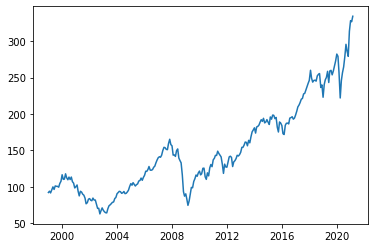

In [70]:
plt.plot(test['Price'])

In [66]:
type(TA125.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [67]:
type(test.index)

pandas.core.indexes.base.Index